## Build RAG Locally on Personal PC with DeepSeek R1-1.5B Model

RAG PDF Dataset: https://github.com/laxmimerit/rag-dataset

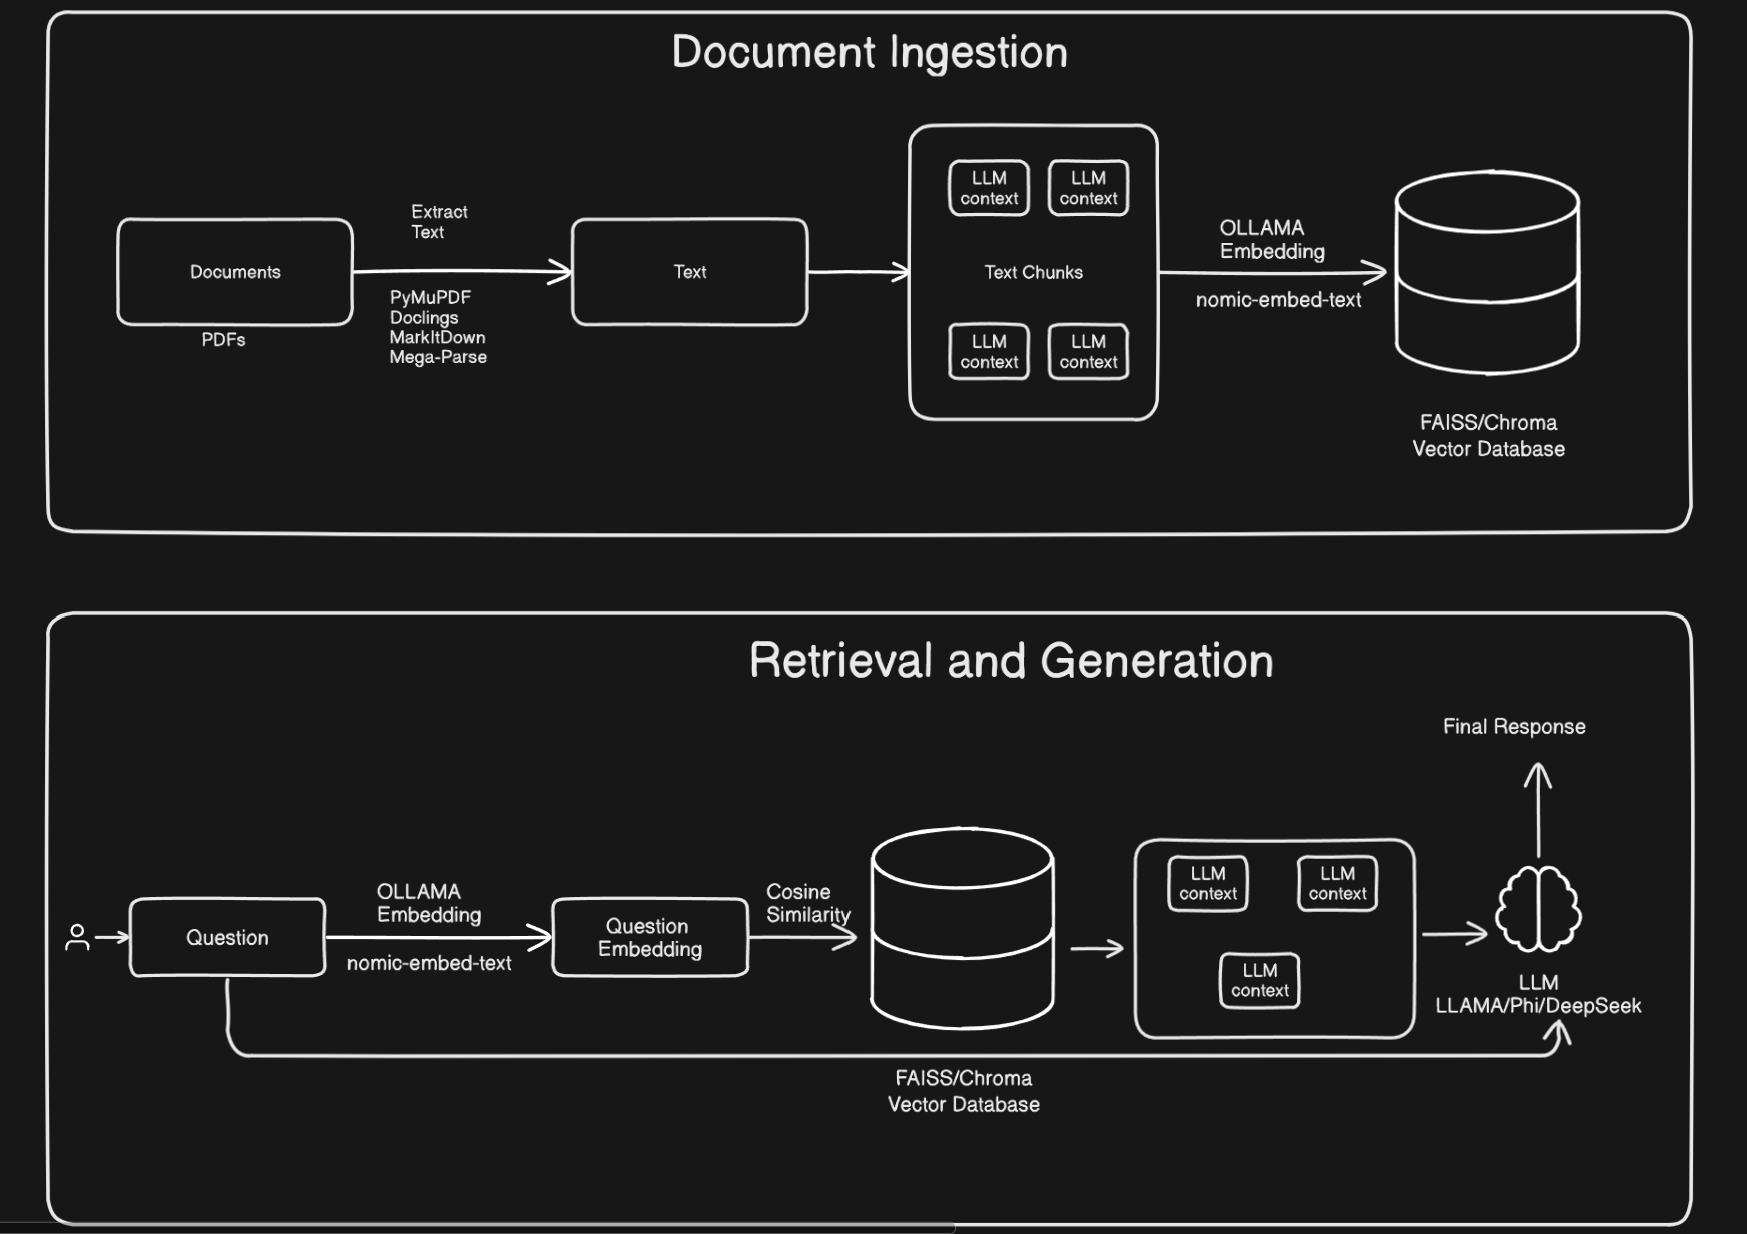

# Sample RAG Questions
You can bring your own questions. This is just sample for testing the RAG system. 

- How much revenue is there for Google?
- What is the net income for this quarter, and what are the key drivers contributing to its increase or decrease?
- Has the company provided guidance for the next quarter or fiscal year? If so, what are the expected revenue and profit margins?
- Which business segment contributed the most to the company's revenue, and what was the percentage growth in that segment?
- How has the stock market reacted to this earnings report, and were there any notable comments from the CEO or CFO about future performance?


In [1]:
# pip install -U langchain langchain-community faiss-cpu langchain-ollama python-dotenv docling langchain-docling

In [2]:
# Environment setup
from dotenv import load_dotenv
import os
import warnings
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
warnings.filterwarnings("ignore")
load_dotenv()

True

In [3]:
import faiss

from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

from langchain_text_splitters import MarkdownHeaderTextSplitter

from langchain_ollama import ChatOllama, OllamaEmbeddings

from docling.document_converter import DocumentConverter


### Document conversion

In [4]:
def load_and_convert_document(file_path):
    converter = DocumentConverter()
    result = converter.convert(file_path)
    return result.document.export_to_markdown()

source = "./rag-dataset/goog-10-q-q3-2024.pdf"
markdown_content = load_and_convert_document(source)

Could not load the custom kernel for multi-scale deformable attention: Command '['where', 'cl']' returned non-zero exit status 1.
Could not load the custom kernel for multi-scale deformable attention: DLL load failed while importing MultiScaleDeformableAttention: The specified module could not be found.
Could not load the custom kernel for multi-scale deformable attention: DLL load failed while importing MultiScaleDeformableAttention: The specified module could not be found.
Could not load the custom kernel for multi-scale deformable attention: DLL load failed while importing MultiScaleDeformableAttention: The specified module could not be found.
Could not load the custom kernel for multi-scale deformable attention: DLL load failed while importing MultiScaleDeformableAttention: The specified module could not be found.
Could not load the custom kernel for multi-scale deformable attention: DLL load failed while importing MultiScaleDeformableAttention: The specified module could not be fo

In [6]:
# print(markdown_content)

### Splitting markdown content into chunks

In [7]:
# Splitting markdown content into chunks
def get_markdown_splits(markdown_content):
    headers_to_split_on = [("#", "Header 1"), ("##", "Header 2"), ("###", "Header 3")]
    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on, strip_headers=False)
    return markdown_splitter.split_text(markdown_content)


chunks = get_markdown_splits(markdown_content)

In [9]:
# print(chunks[13].page_content)

### Embedding and vector store setup

In [10]:
# Embedding and vector store setup
def setup_vector_store(chunks):
    embeddings = OllamaEmbeddings(model='nomic-embed-text', base_url="http://localhost:11434")
    single_vector = embeddings.embed_query("this is some text data")
    index = faiss.IndexFlatL2(len(single_vector))
    vector_store = FAISS(
        embedding_function=embeddings,
        index=index,
        docstore=InMemoryDocstore(),
        index_to_docstore_id={}
    )
    vector_store.add_documents(documents=chunks)
    return vector_store

In [11]:
vector_store = setup_vector_store(chunks)
# Setup retriever
retriever = vector_store.as_retriever(search_type="mmr", search_kwargs={'k': 3})

In [12]:
vector_store.index.ntotal, len(chunks)

(159, 159)

In [17]:
docs = retriever.invoke('what is revenue for september 2024?')
# docs

### Formatting documents for RAG

In [14]:
# Formatting documents for RAG
def format_docs(docs):
    return "\n\n".join([doc.page_content for doc in docs])

content = format_docs(docs)

In [16]:
# print(content)

### Setting up the RAG chain

In [18]:
# Setting up the RAG chain
def create_rag_chain(retriever):
    prompt = """
        You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question.
        If you don't know the answer, just say that you don't know.
        Answer in bullet points. Make sure your answer is relevant to the question and it is answered from the context only.
        ### Question: {question} 
        
        ### Context: {context} 
        
        ### Answer:
    """
    model = ChatOllama(model="deepseek-r1:1.5b", base_url="http://localhost:11434")
    prompt_template = ChatPromptTemplate.from_template(prompt)

    chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt_template
        | model
        | StrOutputParser()
    )
    return chain

### Putting Everything Together

In [19]:
# One-time process

# Load document
source = "rag-dataset/goog-10-q-q3-2024.pdf"
markdown_content = load_and_convert_document(source)
chunks = get_markdown_splits(markdown_content)

# Create vector store
vector_store = setup_vector_store(chunks)

# Setup retriever
retriever = vector_store.as_retriever(search_type="mmr", search_kwargs={'k': 3})

# Create RAG chain
rag_chain = create_rag_chain(retriever)

Could not load the custom kernel for multi-scale deformable attention: DLL load failed while importing MultiScaleDeformableAttention: The specified module could not be found.
Could not load the custom kernel for multi-scale deformable attention: DLL load failed while importing MultiScaleDeformableAttention: The specified module could not be found.
Could not load the custom kernel for multi-scale deformable attention: DLL load failed while importing MultiScaleDeformableAttention: The specified module could not be found.
Could not load the custom kernel for multi-scale deformable attention: DLL load failed while importing MultiScaleDeformableAttention: The specified module could not be found.
Could not load the custom kernel for multi-scale deformable attention: DLL load failed while importing MultiScaleDeformableAttention: The specified module could not be found.
Could not load the custom kernel for multi-scale deformable attention: DLL load failed while importing MultiScaleDeformableAt

In [27]:
# Questions for retrieval
# question = "How much revenue is there for Google in September 2024?"
question = "What is the net income for this quarter, and what are the key drivers contributing to its increase or decrease?"
# question = "Has the company provided guidance for the next quarter or fiscal year? If so, what are the expected revenue and profit margins?"
# question = "Which technology business segment contributed the most to the company's revenue, and what was the percentage growth in that segment?"
# question = "How has the stock market reacted to this earnings report, and were there any notable comments from the CEO or CFO about future performance?"
# question = "ask your own question"

print(f"Question: {question}")
for chunk in rag_chain.stream(question):
    print(chunk, end="", flush=True)
print("\n" + "-" * 50 + "\n")

Question: What is the net income for this quarter, and what are the key drivers contributing to its increase or decrease?
<think>
Okay, so I need to figure out the net income for this quarter and identify what's causing its increase or decrease. Let me go through each part step by step.

First, looking at the context about Other Income (Expense). It mentions that net Other Income primarily comes from foreign currency exchange gains and performance fees. Hmm, I'm not sure how much of this is positive or negative yet. But in the answer, they mention "increases" and "decreases." Maybe this season's Other Income is higher than before.

Next, Google Cloud's operating income increased from $76.693 million to $88.268 million, which is a big jump of over 15%. That must be part of the net income figure they provided. Looking at their table of contents, I see that in the 2024 section for nine months ended September 30, 2024, it's $253,549 million, which is around $81.418 billion. That seems very